In [1]:
%matplotlib inline
%load_ext autoreload
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%autoreload 2
import sys
sys.path.insert(1, '../SyMBac/') # Not needed if you installed SyMBac using pip

import ray
from SyMBac.drawing import  OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
from joblib import Parallel, delayed
from glob import glob
from SyMBac.colony_renderer import ColonyRenderer
import noise
from skimage.filters import threshold_otsu
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.signal import find_peaks
import pandas as pd
from numba import njit
import tifffile
from glob import glob
import pickle
from scipy.signal import find_peaks
import swifter
import scienceplots
import matplotlib
plt.style.use('nature')

matplotlib.rcParams["xtick.minor.bottom"]=False
matplotlib.rcParams["xtick.top"]=False
matplotlib.rcParams["ytick.minor.left"]=False
matplotlib.rcParams["ytick.right"]=False
matplotlib.rcParams["font.size"] = 6
#matplotlib.rcParams["axes.labelpad"] = 0
matplotlib.rcParams["axes.spines.right"] = False
matplotlib.rcParams["axes.spines.top"] = False
matplotlib.rcParams["xtick.minor.visible"] = False
matplotlib.rcParams["ytick.minor.visible"] = False
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["xtick.labelsize"] = 6
matplotlib.rcParams["ytick.labelsize"] = 6
matplotlib.rcParams["axes.titlesize"] = 6
matplotlib.rcParams["axes.labelsize"] = 6
matplotlib.rcParams["grid.alpha"] = 0
matplotlib.rcParams["savefig.transparent"] = True

In [12]:
tqdm.pandas()

In [2]:
def raster_cell(length, width, separation = 0, additional_width = 0, pinching=True):
    """
    Produces a rasterised image of a cell with the intensiity of each pixel corresponding to the optical path length
    (thickness) of the cell at that point.

    :param int length: Cell length in pixels
    :param int width: Cell width in pixels
    :param int separation: An int between (0, `width`) controlling how much pinching is happening.
    :param bool pinching: Controls whether pinching is happening

    Returns
    -------

    cell : np.array
       A numpy array which contains an OPL image of the cell. Can be converted to a mask by just taking ``cell > 0``.

    """

    L = int(np.rint(length))
    W = int(np.rint(width))
    new_cell = np.zeros((L, W))
    R = (W - 1) / 2

    x_cyl = np.arange(0, 2 * R + 1, 1)
    I_cyl = np.sqrt(R ** 2 - (x_cyl - R) ** 2)
    L_cyl = L - W
    new_cell[int(W / 2):-int(W / 2), :] = I_cyl

    x_sphere = np.arange(0, int(W / 2), 1)
    sphere_Rs = np.sqrt((R) ** 2 - (x_sphere - R) ** 2)
    sphere_Rs = np.rint(sphere_Rs).astype(int)

    for c in range(len(sphere_Rs)):
        R_ = sphere_Rs[c]
        x_cyl = np.arange(0, R_, 1)
        I_cyl = np.sqrt(R_ ** 2 - (x_cyl - R_) ** 2)
        new_cell[c, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))
        new_cell[L - c - 1, int(W / 2) - sphere_Rs[c]:int(W / 2) + sphere_Rs[c]] = np.concatenate((I_cyl, I_cyl[::-1]))

    if separation > 2 and pinching:
        S = int(np.rint(separation))
        new_cell[int((L - S) / 2) + 1:-int((L - S) / 2) - 1, :] = 0
        for c in range(int((S+1) / 2)):
            R__ = sphere_Rs[-c - 1]
            x_cyl_ = np.arange(0, R__, 1)
            I_cyl_ = np.sqrt(R__ ** 2 - (x_cyl_ - R__) ** 2)
            new_cell[int((L-S) / 2) + c + 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
            new_cell[-int((L-S) / 2) - c - 1, int(W / 2) - R__:int(W / 2) + R__] = np.concatenate((I_cyl_, I_cyl_[::-1]))
    new_cell = new_cell.astype(int)
            
    
    if additional_width>=1:
        additional_width = int(additional_width)
        wide_cell = np.zeros((new_cell.shape[0], int(new_cell.shape[1] + additional_width)))
        wide_cell[:,:new_cell.shape[1]//2] = new_cell[:,:new_cell.shape[1]//2]
        wide_cell[:,new_cell.shape[1]//2 + additional_width:] = new_cell[:,new_cell.shape[1]//2:]
        wide_cell[:,new_cell.shape[1]//2:new_cell.shape[1]//2 + additional_width] = np.repeat(new_cell[:,new_cell.shape[1]//2].reshape(-1,1), additional_width, axis=1)
        return wide_cell
    
    if additional_width<=1:
        new_cell[np.where(new_cell)] += int(abs(additional_width))
    
    return new_cell

@njit
def generate_deviation_from_CL(centreline, thickness):
    return np.arange(thickness) + centreline - int(np.ceil(thickness ))

@njit
def gen_3D_coords_from_2D(test_cells, centreline, thickness):
    return np.where(test_cells == thickness) + (generate_deviation_from_CL(centreline, thickness),)

@njit
def convert_to_3D_numba(cell):
    expanded_scene = cell
    volume_shape = expanded_scene.shape[0:] + (int(expanded_scene.max()*2),)
    test_cells = rounder(expanded_scene)
    centreline = int(expanded_scene.max() )
    cells_3D = np.zeros(volume_shape,dtype = np.ubyte)
    for t in range(int(expanded_scene.max() *2 )):
        test_coords = gen_3D_coords_from_2D(test_cells, centreline, t)
        for x, y in zip(test_coords[0], (test_coords[1])):
            for z in test_coords[2]:
                cells_3D[x, y, z] = 1
    return cells_3D

def convert_to_3D(cell):
    cells_3D = convert_to_3D_numba(cell)
    cells_3D = np.moveaxis(cells_3D, -1, 0)
    cells_3D[cells_3D.shape[0]//2:,:, :] = cells_3D[:cells_3D.shape[0]//2,:, :][::-1]
    return cells_3D
    #cells_3D = np.pad(cells_3D, ((100,100), (50,50), (50,50)))
#cells_3D.shape

@njit
def rounder(x):
    out = np.empty_like(x)
    np.round(x, 0, out)
    return out

def raster_membrane_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):


    membrane_thickness = 0.05 #micron
    raster_membrane_thickness = membrane_thickness/pix_mic_conv * resize_amount
    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)
    cell_2 = raster_cell(length=round((raster_cell_length - raster_membrane_thickness)/2)*2, width=round((raster_cell_width - raster_membrane_thickness)/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    cell_2_3d = convert_to_3D(cell_2)

    
    pad_1 = int((cell_1_3d.shape[0] - cell_2_3d.shape[0])/2)
    pad_2 = int((cell_1_3d.shape[1] - cell_2_3d.shape[1])/2)
    pad_3 = int((cell_1_3d.shape[2] - cell_2_3d.shape[2])/2)

    cell_2_3d = np.pad(cell_2_3d, ((pad_1,pad_1), (pad_2, pad_2), (pad_3, pad_3)))
    
    cell_3d = cell_1_3d - cell_2_3d
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

def raster_cell_3d(raster_cell_length, raster_cell_width, raster_slice_amount):

    cell_1 = raster_cell(length=round(raster_cell_length/2)*2, width=round(raster_cell_width/2)*2, additional_width=raster_additional_width)

    cell_1_3d = convert_to_3D(cell_1)
    
    cell_3d = cell_1_3d 
    
    if raster_slice_amount:
        
        cell_3d = cell_3d[int(raster_slice_amount//2):-int(raster_slice_amount//2),:,:]
    
    return cell_3d

additional_width = 0
raster_additional_width = 0

In [3]:
pix_mic_conv = 0.065 / 15

In [4]:
files = sorted(glob("targeted_simulation_output_cyto/*"))

In [5]:
file = files[3]

In [6]:
file.split("/")[-1].split("_")

['0.52', 'tPSF', '0.5.tiff']

In [7]:
from collections import namedtuple


def get_info_and_image(file):
    split_string = file.split("/")[-1].split("_")
    if len(split_string) == 4:
        width, _, PSF_type, colour = split_string
    elif len(split_string) == 3:
        width, PSF_type, colour = split_string
    width = float(width)
    colour = colour.split(".tiff")[0]
    #image = tifffile.imread(file)


    
    return (width, PSF_type, colour, file)

file_info_list = [get_info_and_image(file) for file in tqdm(files)]



  0%|          | 0/156 [00:00<?, ?it/s]

In [13]:
columns = ['True Width', 'PSF Type', 'Colour', 'Directory']

data = pd.DataFrame(file_info_list, columns=columns)

In [14]:
def get_profile(directory):
    image = tifffile.imread(directory).sum(axis=0)
    y_midpoint = image.shape[0]//2
    profile = image[y_midpoint]
    profile = profile/profile.max()
    return profile

In [16]:
data['Profile'] = data['Directory'].progress_apply(get_profile)

  0%|          | 0/156 [00:00<?, ?it/s]

In [19]:
def get_profile_0_DoF(directory):
    image = tifffile.imread(directory)
    z_midpoint = image.shape[0]//2
    image = image[z_midpoint]
    y_midpoint = image.shape[0]//2
    profile = image[y_midpoint]
    profile = profile/profile.max()
    return profile

In [20]:
data['Profile 0 DoF'] = data['Directory'].progress_apply(get_profile_0_DoF)

  0%|          | 0/156 [00:00<?, ?it/s]

In [52]:
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

def get_width(y):
    x = np.arange(len(y))
    peak_index = np.argmax(y)
    half_max = y[peak_index] / 2

    # Find index where y first drops below half_max on the left side of the peak
    left_idx = np.where(y[:peak_index] < half_max)[0]
    if left_idx.size > 0:
        left_idx = left_idx[-1]
        # Linear interpolation for more accuracy
        if left_idx + 1 < len(y):
            left_interp = interp1d(y[left_idx:left_idx + 2], x[left_idx:left_idx + 2])
            left_interpolated = left_interp(half_max)
        else:
            left_interpolated = x[left_idx]
    else:
        left_interpolated = x[0]

    # Find index where y first drops below half_max on the right side of the peak
    right_idx = np.where(y[peak_index:] < half_max)[0]
    if right_idx.size > 0:
        right_idx = right_idx[0] + peak_index
        # Linear interpolation for more accuracy
        if right_idx > 0:
            right_interp = interp1d(y[right_idx - 1:right_idx + 1], x[right_idx - 1:right_idx + 1])
            right_interpolated = right_interp(half_max)
        else:
            right_interpolated = x[right_idx]
    else:
        right_interpolated = x[-1]

    # Calculate FWHM
    fwhm = right_interpolated - left_interpolated
    return fwhm*pix_mic_conv

In [23]:
#def get_width(profile):
#    peaks = find_peaks(profile, height = 0.9, prominence=0.05)[0]
#    if len(peaks) == 2:
#        return np.diff(peaks)[0] * pix_mic_conv
#    elif len(peaks) == 1:
#        return 0
#    elif len(peaks) > 2:
#        raise AssertionError

In [24]:
data['Observed Width'] = data['Profile'].apply(get_width)

In [25]:
data['Observed Width 0 DoF'] = data['Profile 0 DoF'].apply(get_width)

In [26]:
def get_wavelength(colour):
    if colour == "darkred":
        return 0.7
    elif colour == "green":
        return 0.5
    else:
        return colour

In [27]:
data['Wavelength'] = data['Colour'].apply(get_wavelength)

In [28]:
import seaborn as sns

In [29]:
data["Wavelength"] = data["Wavelength"].astype(float)

In [30]:
data.columns

Index(['True Width', 'PSF Type', 'Colour', 'Directory', 'Profile',
       'Profile 0 DoF', 'Observed Width', 'Observed Width 0 DoF',
       'Wavelength'],
      dtype='object')

In [33]:
# Rename the existing 'Profile' column
data = data.rename(columns={'Profile': 'Existing Profile'})

# List of columns to retain (all columns except 'Profile 0 DoF' and 'Profile')
id_columns = [col for col in data.columns if col not in ['Profile 0 DoF', 'Existing Profile']]

# Perform the melting operation
melted_data = data.melt(id_vars=id_columns, 
                        value_vars=['Profile 0 DoF', 'Existing Profile'], 
                        var_name='Profile type', 
                        value_name='Profile')

# Adjust the 'Profile type' values
melted_data['Profile type'] = melted_data['Profile type'].replace({'Profile 0 DoF': '0 DoF', 'Existing Profile': 'Width DoF'})

melted_data.head()


,True Width,PSF Type,Colour,Directory,Observed Width,Observed Width 0 DoF,Wavelength,Profile type,Profile
0,0.52,ePSF,darkred,targeted_simulation_output_cyto/0.52_iPSF_ePSF...,135.772126,153.261746,0.7,0 DoF,"[0.2947565705721415, 0.2982540204683075, 0.301..."
1,0.52,ePSF,green,targeted_simulation_output_cyto/0.52_iPSF_ePSF...,121.498652,134.897260,0.5,0 DoF,"[0.17914206135274396, 0.1812870947051215, 0.18..."
2,0.52,tPSF,0.4,targeted_simulation_output_cyto/0.52_tPSF_0.4....,108.622033,119.478155,0.4,0 DoF,"[0.0038694068889722558, 0.0039890347498548456,..."
3,0.52,tPSF,0.5,targeted_simulation_output_cyto/0.52_tPSF_0.5....,108.401245,120.310052,0.5,0 DoF,"[0.004279060903052279, 0.004410338210370989, 0..."
4,0.52,tPSF,0.6,targeted_simulation_output_cyto/0.52_tPSF_0.6....,108.320200,121.008006,0.6,0 DoF,"[0.004961845045253567, 0.005066207440118057, 0..."


In [53]:
melted_data['Observed Width'] = melted_data['Profile'].apply(get_width)

In [54]:
melted_data["Observed Width / True Width"] = melted_data["Observed Width"] / melted_data["True Width"]

In [67]:
melted_data.to_pickle("membrane_targeted_simulation_data_cyto.pickle")

In [68]:
melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF'")

,True Width,PSF Type,Colour,Directory,Observed Width,Observed Width 0 DoF,Wavelength,Profile type,Profile,Observed Width / True Width
186,1.02,ePSF,darkred,targeted_simulation_output_cyto/1.019999999999...,1.035158,274.069026,0.7,Width DoF,"[0.2729451492537979, 0.2751580685761608, 0.277...",1.014861
187,1.02,ePSF,green,targeted_simulation_output_cyto/1.019999999999...,0.989502,248.607414,0.5,Width DoF,"[0.19592056292507928, 0.19797597522894034, 0.2...",0.970100
188,1.02,tPSF,0.4,targeted_simulation_output_cyto/1.019999999999...,0.954547,234.612298,0.4,Width DoF,"[0.003988646627405657, 0.004158390337740272, 0...",0.935831
189,1.02,tPSF,0.5,targeted_simulation_output_cyto/1.019999999999...,0.947284,234.816679,0.5,Width DoF,"[0.004299476802379675, 0.004477740403718901, 0...",0.928709
190,1.02,tPSF,0.6,targeted_simulation_output_cyto/1.019999999999...,0.941189,235.139427,0.6,Width DoF,"[0.004680596061466006, 0.00486772690112046, 0....",0.922734
191,1.02,tPSF,0.7,targeted_simulation_output_cyto/1.019999999999...,0.935309,235.427770,0.7,Width DoF,"[0.005056502344679773, 0.005266809708698223, 0...",0.916969


In [69]:
pix_mic_conv = 0.065 / 15
resize_amount = 1
sim_width = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'ePSF'")["True Width"].iloc[0]

In [70]:
a_cell = np.pad(raster_cell_3d(3/pix_mic_conv, sim_width/pix_mic_conv, 0), ((0,0), (50, 50), (50,50)))
unconv_profile = a_cell.sum(axis=0)[a_cell.shape[1]//2]
unconv_profile = unconv_profile/unconv_profile.max()

In [71]:
plot_profile_red = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.7 & `PSF Type` == 'ePSF'")["Profile"].iloc[0]
plot_profile_red = plot_profile_red/plot_profile_red.max()

plot_profile_green = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.5 & `PSF Type` == 'ePSF'")["Profile"].iloc[0]
plot_profile_green = plot_profile_green/plot_profile_green.max()

plot_profile_green_tPSF = melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF' & Wavelength == 0.5 & `PSF Type` == 'tPSF'")["Profile"].iloc[0]
plot_profile_green_tPSF = plot_profile_green_tPSF/plot_profile_green_tPSF.max()

(-0.7, 0.7)

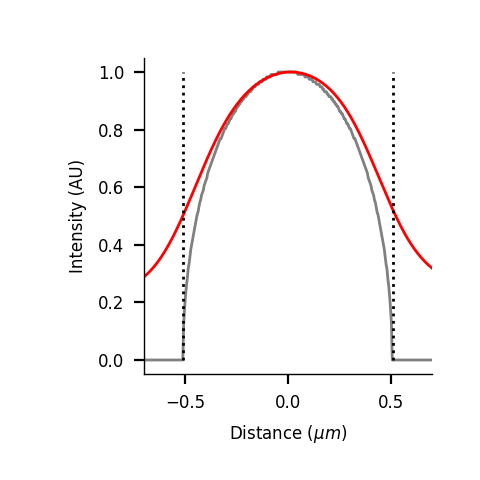

In [72]:
fig, ax = plt.subplots(1,1, figsize=(2.4,2.4), dpi = 200)
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.3, bottom=0.22)

x_axis = np.arange(-len(unconv_profile)/2,len(unconv_profile)/2) * pix_mic_conv
plt.plot(x_axis,unconv_profile, c = "grey")
plt.plot(x_axis,plot_profile_red, c = "red")
left_border = np.nonzero(unconv_profile)[0][0]
right_border = np.nonzero(unconv_profile)[0][-1]
plt.plot([-sim_width/2, -sim_width/2],[0,1], c = "k", linestyle = ":")
plt.plot([sim_width/2, sim_width/2],[0,1], c = "k", linestyle = ":")
plt.xlim(-0.7,0.7)

(0.3, 0.7)

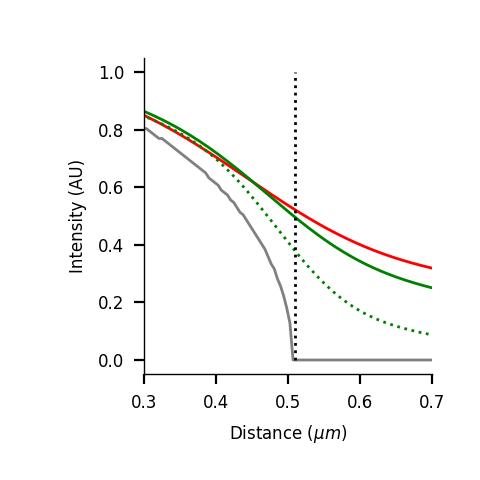

In [73]:
fig, ax = plt.subplots(1,1, figsize=(2.4,2.4), dpi = 200)
plt.xlabel("Distance ($\mu m$)")
plt.ylabel("Intensity (AU)")
plt.subplots_adjust(left=0.3, bottom=0.22)
x_axis = np.arange(-len(unconv_profile)/2,len(unconv_profile)/2) * pix_mic_conv
tPSF_x_axis = np.arange(-len(plot_profile_green_tPSF)/2,len(plot_profile_green_tPSF)/2) * pix_mic_conv
plt.plot(x_axis,unconv_profile, c = "grey")
plt.plot(x_axis,plot_profile_red, c = "red")
plt.plot(x_axis,plot_profile_green, c = "green")
plt.plot(tPSF_x_axis,plot_profile_green_tPSF, c = "green", linestyle = ":")

left_border = np.nonzero(unconv_profile)[0][0]
right_border = np.nonzero(unconv_profile)[0][-1]
plt.plot([-sim_width/2, -sim_width/2],[0,1], c = "k", linestyle = ":")
plt.plot([sim_width/2, sim_width/2],[0,1], c = "k", linestyle = ":")
plt.xlim(0.3,0.7)


Text(0, 0.5, 'Observed / True width')

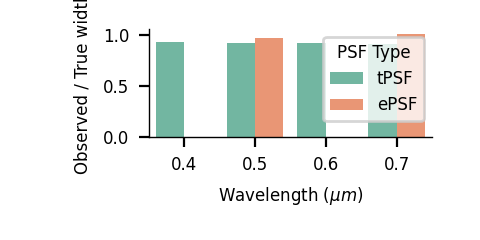

In [74]:
fig, ax = plt.subplots(1,1, figsize=(2.4,1.2), dpi = 200)
sns.barplot(melted_data.query("`True Width` < 1.05 & `True Width` > 1 & `Profile type` == 'Width DoF'"), x = "Wavelength", y = "Observed Width / True Width", hue = "PSF Type", palette="Set2")
plt.subplots_adjust(left=0.31, bottom=0.43)
plt.xlabel("Wavelength ($\mu m$)")
plt.ylabel("Observed / True width")

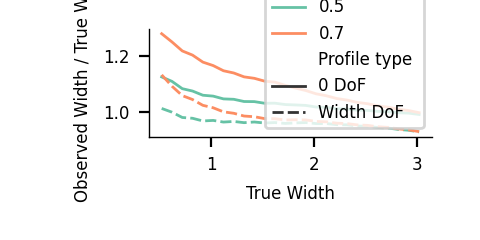

In [75]:
fig, ax = plt.subplots(1,1, figsize=(2.4,1.2), dpi = 200)
sns.lineplot(melted_data.query("`PSF Type` == 'ePSF'"), x = "True Width", y = "Observed Width / True Width", hue = "Wavelength", style="Profile type", palette="Set2")
plt.subplots_adjust(left=0.31, bottom=0.43)
